<a href="https://colab.research.google.com/github/ILoveSorasakiHina/MNIST-CNN/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd

np.random.seed(0)
import random

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [4]:
from google.colab import drive
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟

Mounted at /content/gdrive


In [5]:
#讀入檔案
train = pd.read_csv("/content/gdrive/My Drive/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/test.csv")

X_train = train.drop(labels = ["label"], axis = 1)
y_train = train['label']

X_test = test

print(y_train)
print(X_train.shape, X_test.shape)

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64
(42000, 784) (28000, 784)


In [6]:
#轉換為28x28的二維圖片
X_train_plot = X_train.values.reshape(-1, 28, 28)
print(X_train_plot[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 188 255  94   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 191 250 253  93   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  123 248 253 167  10   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  80
  247 253 208  13   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

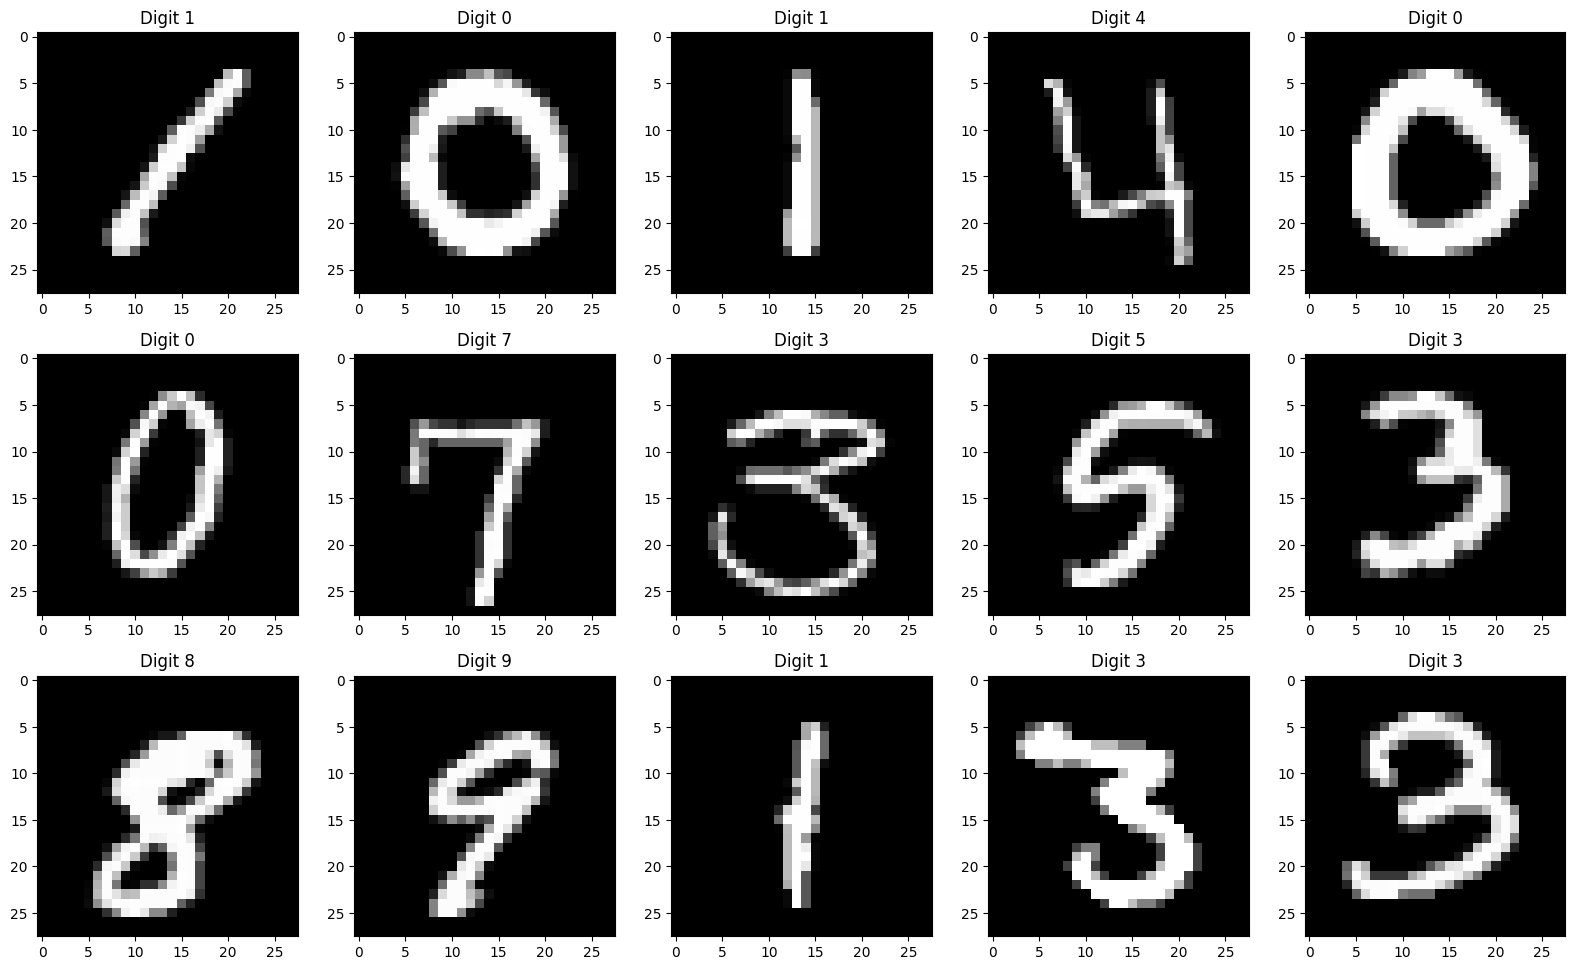

In [7]:
#展示圖片，顏色為黑白
def Show_example_digits(mono = 'gray'):
  #開一個16*16英寸的畫布
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
      #15個子圖
        plt.subplot(5, 5,idx+1)
        plt.imshow(X_train_plot[idx], cmap = mono)
        plt.title("Digit {}".format(y_train[idx]))

    plt.tight_layout()

Show_example_digits()

In [8]:
def plot_digit(digit, dem = 28, font_size = 12):
    max_ax = font_size * dem
  #圖片為13*13英寸，x軸y軸長度為max_ax
    fig = plt.figure(figsize=(13, 13))
    plt.xlim([0, max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    black = '#000000'

    for idx in range(dem):
        for jdx in range(dem):

          #text(x,y,欲輸入的文字內容，字體大小，顏色)
            t = plt.text(idx * font_size, max_ax - jdx*font_size, digit[jdx][idx], fontsize = font_size, color = black)
          #轉化為灰度值
            c = digit[jdx][idx] / 255.
            t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black'))

    plt.show()


7


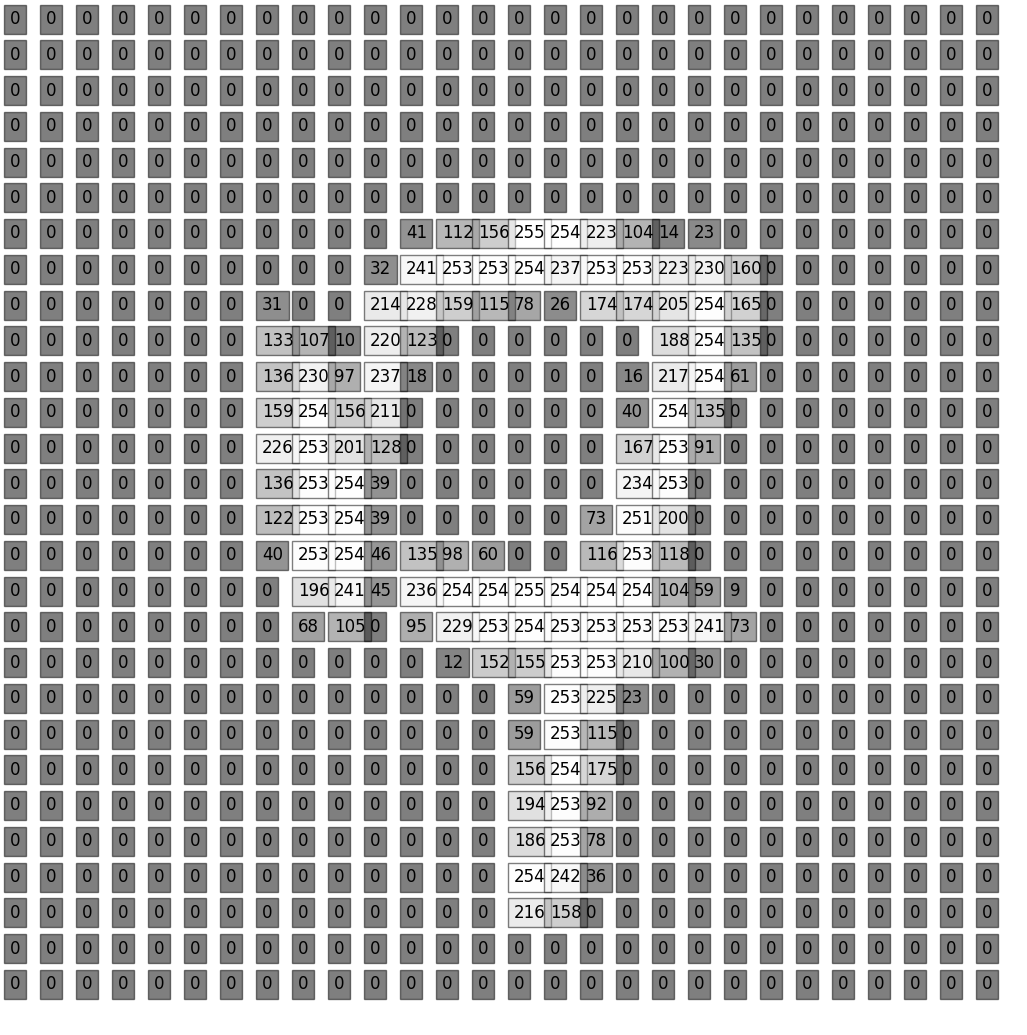

In [9]:
#隨機生成數字
rand_number = random.randint(0, len(y_train))
print(y_train[rand_number])
plot_digit(X_train_plot[rand_number])


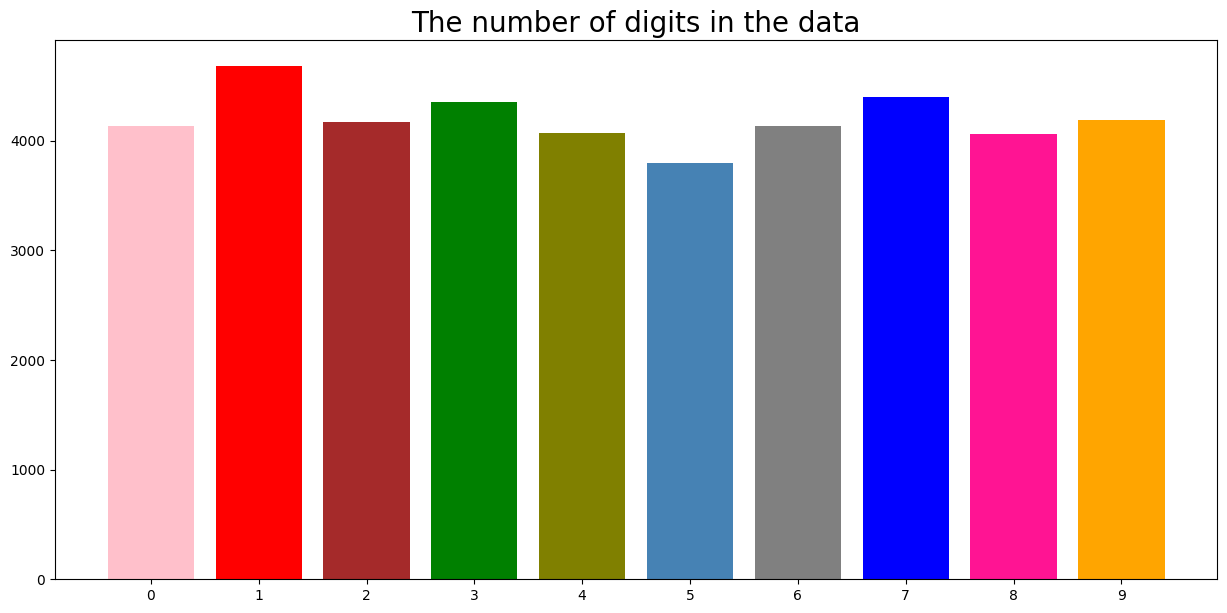

In [10]:
#統計各數字數量
digit_range = np.arange(10)

val = y_train.value_counts().index
cnt = y_train.value_counts().values
mycolors = ['red', 'blue', 'green', 'orange', 'brown', 'grey', 'pink', 'olive', 'deeppink', 'steelblue']

plt.figure(figsize = (15, 7))
plt.title("The number of digits in the data", fontsize = 20)
plt.xticks(range(10))
plt.bar(val, cnt, color = mycolors);

In [11]:
img_rows, img_cols = 28, 28

num_pixels = X_train.shape[1]

input_shape = (img_rows, img_cols)

In [12]:
# Data Normalization [0, 1]
X_train /= 255
X_test /= 255

# one-hot encoding for target column
y_train = to_categorical(y_train)

# | [0, 1, 2, ... , 9] | = 10
num_classes = y_train.shape[1]
print(num_classes)

# Number of objects, vector size (28 * 28)
print(X_train.shape, X_test.shape)


10
(42000, 784) (28000, 784)


In [13]:
#切分驗證資料與訓練資料
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2, stratify=y_train)

In [14]:
#f1 score 此為檢驗標準
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [15]:
def draw_learning_curve(history, keys=['f1', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()


In [16]:
def callbacks(name):
    return [
        EarlyStopping(monitor = 'loss', patience = 6),
        ReduceLROnPlateau(monitor = 'loss', patience = 3),
        ModelCheckpoint(f'../working/{name}.hdf5', save_best_only=True) # saving the best model
    ]


In [17]:
def get_mlp():

    return Sequential([
        #input layer is automatic generation by keras

        #hidden layer
        Dense(512, input_dim = num_pixels, activation='relu'),

        #output layer
        Dense(num_classes, activation='softmax')
    ])


In [18]:
model = get_mlp()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('simple_mlp'),
          validation_data=(X_val, y_val));


Epoch 1/40
37/37 - 2s - loss: 0.7292 - f1: 0.6996 - val_loss: 0.3363 - val_f1: 0.9023 - lr: 0.0010 - 2s/epoch - 67ms/step
Epoch 2/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 - 1s - loss: 0.2760 - f1: 0.9221 - val_loss: 0.2539 - val_f1: 0.9301 - lr: 0.0010 - 1s/epoch - 36ms/step
Epoch 3/40
37/37 - 2s - loss: 0.2142 - f1: 0.9404 - val_loss: 0.2070 - val_f1: 0.9430 - lr: 0.0010 - 2s/epoch - 50ms/step
Epoch 4/40
37/37 - 1s - loss: 0.1754 - f1: 0.9520 - val_loss: 0.1779 - val_f1: 0.9496 - lr: 0.0010 - 1s/epoch - 37ms/step
Epoch 5/40
37/37 - 2s - loss: 0.1475 - f1: 0.9594 - val_loss: 0.1553 - val_f1: 0.9546 - lr: 0.0010 - 2s/epoch - 45ms/step
Epoch 6/40
37/37 - 2s - loss: 0.1258 - f1: 0.9660 - val_loss: 0.1401 - val_f1: 0.9564 - lr: 0.0010 - 2s/epoch - 61ms/step
Epoch 7/40
37/37 - 2s - loss: 0.1106 - f1: 0.9699 - val_loss: 0.1269 - val_f1: 0.9591 - lr: 0.0010 - 2s/epoch - 54ms/step
Epoch 8/40
37/37 - 3s - loss: 0.0952 - f1: 0.9746 - val_loss: 0.1211 - val_f1: 0.9629 - lr: 0.0010 - 3s/epoch - 86ms/step
Epoch 9/40
37/37 - 1s - loss: 0.0840 - f1: 0.9776 - val_loss: 0.1124 - val_f1: 0.9638 - lr: 0.0010 - 1s/epoch - 37ms/step
Epoch 10/40
37/37 - 1s - loss: 0.07

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

In [ ]:
draw_learning_curve(learning_history)


In [ ]:
def get_mlpv2():

    return Sequential([
        Dense(512, input_dim=num_pixels, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])


In [ ]:
model = get_mlpv2()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

In [ ]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('mlp_reg'),
          validation_data=(X_val, y_val));


In [ ]:
draw_learning_curve(learning_history)


In [ ]:
X_train.shape


In [ ]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_val = X_val.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)

In [ ]:
def get_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),


        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")

    ])


In [ ]:
model = get_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()


In [ ]:
learning_history = model.fit(X_train, y_train,
          batch_size = 128,
          epochs = 50,
          verbose = 1,
          callbacks = callbacks('cnn_v1'),
          validation_data = (X_val, y_val))

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

In [ ]:
draw_learning_curve(learning_history)


In [ ]:
y_pred = model.predict(X_val)


In [ ]:
def draw_output(idx_nums):
    plt.figure(figsize = (20, 20))
    plt.xticks( range(10) )
    x = np.ceil(np.sqrt(len(idx_nums)))
    cnt = 1
    for ph in idx_nums:
        plt.subplot(x, x, cnt)
        curr_photo = y_val[ph]

        plt.xlim(0, 10)
        plt.title("Digit: {0}\n idx: {1} ".format(np.argmax(y_val[ph]), ph), fontsize = 10)
        plt.bar(range(10), y_pred[ph])

        cnt += 1

In [ ]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    cnt_error.append( (np.argmax(a)) )


cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
bar_plot = sns.barplot(x=cnt_error[0], y=cnt_error[1], palette="muted")
plt.show()


In [ ]:
cnt_ind = 1
list_idx = []
X_val_plot = X_val.reshape( X_val.shape[:-1] )
fig = plt.figure(figsize=(14, 14))

for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    if (np.argmax(a) == 2 or np.argmax(a) == 9):
        plt.subplot(5, 5, cnt_ind)
        plt.imshow(X_val_plot[idx], cmap='gray', interpolation='none')
        plt.title('y_true={0}\ny_pred={1}\n ind = {2}'.format(np.argmax(a), np.argmax(b), idx))
        plt.tight_layout()
        list_idx.append(idx)
        cnt_ind += 1



In [ ]:
train_aug = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest',
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1)


train_aug.fit(X_train)
train_gen = train_aug.flow(X_train, y_train, batch_size=64)

In [ ]:
def get_cnn_v2():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),


        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(num_classes, activation = "softmax")

    ])


In [ ]:
model = get_cnn_v2()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()


In [ ]:
learning_history = model.fit_generator(train_gen, epochs = 100,
                               steps_per_epoch = X_train.shape[0] // 64,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks('best_cnn'),
                             )

In [ ]:
model = load_model('../working/best_cnn.hdf5', custom_objects={"f1": f1})


In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))


In [ ]:
draw_learning_curve(learning_history)


In [ ]:
output = model.predict(X_test)

output = np.argmax(output, axis = 1)

output = pd.Series(output, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), output], axis = 1)

submission.to_csv("submission.csv", index=False)


In [ ]:
!ls